<a href="https://colab.research.google.com/github/RemonRezk/AMP_PROJECT_DSE/blob/main/AMD_MBA_IMDB_PROJECT_REMON_REZK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ALGORITHMS FOR MASSIVE DATA
### Project 2: MARKET BASKET ANALYSIS - IMDB DATASET

The task is to implement a system finding frequent itemsets (aka market-basket analysis), analyzing one of the two datasets described below. <br>

The «IMDB» dataset is published on Kaggle, under IMDb non-commercial licensing. The analysis must be done considering movies as baskets and actors as items.


Set the spark session and spark context

In [1]:
#!apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark

     |████████████████████████████████| 212.4 MB 56 kB/s 
     |████████████████████████████████| 198 kB 47.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=89406221071d95c0f2b5385c23ec934f9f9d60e8e3b35d6e1c2674bc108cfc44
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [3]:
import findspark
findspark.init("spark-3.1.2-bin-hadoop3.2")

from pyspark.sql import SparkSession
spark = SparkSession.builder.enableHiveSupport().getOrCreate()
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

In [4]:
import pyspark
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, size, collect_set
import pyspark.sql.functions as F
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt
import pickle
from tqdm.auto import tqdm
import time
import itertools
import functools
import operator
from pyspark.ml.fpm import FPGrowth
from google.colab import drive, files

# DATA DOWNLOAD
Download IMDB dataset from Kaggle through Kaggle API

In [5]:
!pip install -q kaggle
uploaded = files.upload() #to upload kaggle.json api

Saving kaggle.json to kaggle.json


In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!ls ~/.kaggle

! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list &> /dev/null

kaggle.json


In [7]:
!kaggle datasets download -d ashirwadsangwan/imdb-dataset

100% 1.43G/1.44G [00:27<00:00, 68.9MB/s]
100% 1.44G/1.44G [00:27<00:00, 55.3MB/s]


Create a directory where the dataset is downloaded and remove the useless folders

In [8]:
! mkdir -p dataset 
! unzip imdb-dataset.zip -d dataset &> /dev/null

# DATA IMPORTING, CLEASING & EXPLORATORY ANALYSIS


In [9]:
path = "/content/dataset/"

names = spark.read.csv(path + "name.basics.tsv", header=True, inferSchema=True, sep=r'\t')
akas = spark.read.csv(path + "title.akas.tsv", header=True, inferSchema=True, sep=r'\t')
basics = spark.read.csv(path + "title.basics.tsv", header=True, inferSchema=True, sep=r'\t')
principles = spark.read.csv(path + "title.principals.tsv", header=True, inferSchema=True, sep=r'\t')
ratings = spark.read.csv(path + "title.ratings.tsv", header=True, inferSchema=True, sep=r'\t')

In [10]:
names.createOrReplaceTempView("names")
akas.createOrReplaceTempView("akas")
basics.createOrReplaceTempView("basics")
principles.createOrReplaceTempView("principles")
ratings.createOrReplaceTempView("ratings")

In [11]:
names.show(5,False)
akas.show(5,False)
basics.show(5,False)
principles.show(5,False)
ratings.show(5,False)

+---------+---------------+---------+---------+------------------------------+---------------------------------------+
|nconst   |primaryName    |birthYear|deathYear|primaryProfession             |knownForTitles                         |
+---------+---------------+---------+---------+------------------------------+---------------------------------------+
|nm0000001|Fred Astaire   |1899     |1987     |soundtrack,actor,miscellaneous|tt0050419,tt0053137,tt0072308,tt0043044|
|nm0000002|Lauren Bacall  |1924     |2014     |actress,soundtrack            |tt0071877,tt0117057,tt0038355,tt0037382|
|nm0000003|Brigitte Bardot|1934     |\N       |actress,soundtrack,producer   |tt0054452,tt0049189,tt0059956,tt0057345|
|nm0000004|John Belushi   |1949     |1982     |actor,writer,soundtrack       |tt0077975,tt0072562,tt0080455,tt0078723|
|nm0000005|Ingmar Bergman |1918     |2007     |writer,director,actor         |tt0069467,tt0050976,tt0083922,tt0050986|
+---------+---------------+---------+---------+-

In [12]:
print('Total number of rows for names data file:', names.count())
print('Total number of rows for title_akas data file',akas.count())
print('Total number of rows for title_basics data file:', basics.count())
print('Total number of rows for title_principles data file:', principles.count())
print('Total number of rows for title_ratings data file:', ratings.count())

Total number of rows for names data file: 9706922
Total number of rows for title_akas data file 19527971
Total number of rows for title_basics data file: 6321302
Total number of rows for title_principles data file: 36468817
Total number of rows for title_ratings data file: 993153


In [13]:
# Remove Duplicates
names.dropDuplicates()
akas.dropDuplicates()
basics.dropDuplicates()
principles.dropDuplicates()
ratings.dropDuplicates()

DataFrame[tconst: string, averageRating: double, numVotes: int]

In [14]:
# Check number of rows after remove duplicates
print('Total number of rows for names data file:',names.count())
print('Total number of rows for title_akas data file',akas.count())
print('Total number of rows for title_basics data file:', basics.count() )
print('Total number of rows for title_principles data file:', principles.count())
print('Total number of rows for title_ratings data file:', ratings.count())

Total number of rows for names data file: 9706922
Total number of rows for title_akas data file 19527971
Total number of rows for title_basics data file: 6321302
Total number of rows for title_principles data file: 36468817
Total number of rows for title_ratings data file: 993153


In [15]:
# Build a Master Data Table
master_data_tb = ( principles
 .join(basics, principles.tconst == basics.tconst,how='inner')
 .join(names, principles.nconst == names.nconst, how='inner')
 .join(ratings, principles.tconst == ratings.tconst, how='inner')
 .select(principles.tconst.alias('movie_id'), basics.primaryTitle.alias('movie_name'),principles.nconst.alias('actor_id'), names.primaryName.alias('actor_name'),names.primaryProfession,basics.primaryTitle.alias('movie_name'),basics.titleType,principles.category,ratings.averageRating,ratings.numVotes,names.knownForTitles,basics.startYear,basics.genres,basics.isAdult)
 #filter((principles.category == 'actor' OR principles.category=='actress') and (basics.titleType=='movie'))
 .orderBy(principles.tconst) )

master_data_tb.show(5, False)

+---------+----------------------+---------+--------------------+---------------------------------+----------------------+---------+---------------+-------------+--------+---------------------------------------+---------+-----------------+-------+
|movie_id |movie_name            |actor_id |actor_name          |primaryProfession                |movie_name            |titleType|category       |averageRating|numVotes|knownForTitles                         |startYear|genres           |isAdult|
+---------+----------------------+---------+--------------------+---------------------------------+----------------------+---------+---------------+-------------+--------+---------------------------------------+---------+-----------------+-------+
|tt0000001|Carmencita            |nm0005690|William K.L. Dickson|cinematographer,director,producer|Carmencita            |short    |director       |5.6          |1550    |tt1496763,tt1428455,tt0219560,tt6687694|1894     |Documentary,Short|0      |
|tt00000

Count the number of unique IDs of movies and actors and the number of unique actor names and movie titles.

In [16]:
master_data_tb.dropDuplicates()

DataFrame[movie_id: string, movie_name: string, actor_id: string, actor_name: string, primaryProfession: string, movie_name: string, titleType: string, category: string, averageRating: double, numVotes: int, knownForTitles: string, startYear: string, genres: string, isAdult: int]

In [17]:
# Cache the dataset since it will be used often
master_data_tb.cache()

DataFrame[movie_id: string, movie_name: string, actor_id: string, actor_name: string, primaryProfession: string, movie_name: string, titleType: string, category: string, averageRating: double, numVotes: int, knownForTitles: string, startYear: string, genres: string, isAdult: int]

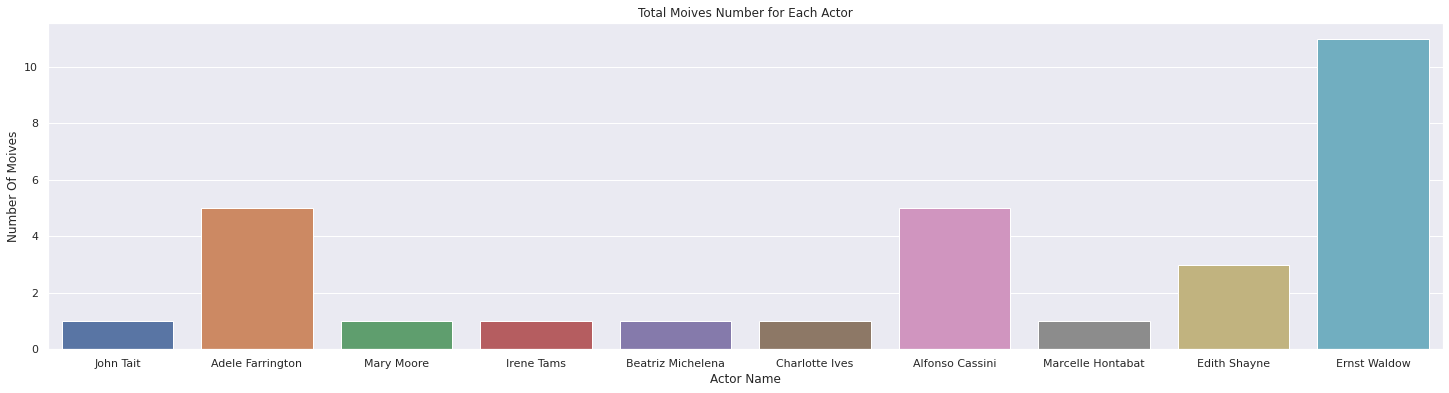

In [18]:
master_data_tb.createOrReplaceTempView('master_data_tb')

query = """
  SELECT  DISTINCT actor_name, COUNT(movie_id) AS movies_count
  FROM    master_data_tb
  WHERE   (category == 'actor' OR category=='actress') AND (titleType=='movie')
  GROUP   BY actor_name
  Limit   10
"""

res = spark.sql(query)

sns.set_style("darkgrid")
sns.set(rc={"figure.figsize":(25,6)})
ax = sns.barplot(x = "actor_name", y = "movies_count", data = res.toPandas())
ax.set(title = "Total Moives Number for Each Actor", xlabel = "Actor Name", ylabel = "Number Of Moives");
# it takes time to run around 8 mins

▶ These are the top 10 actors participated in movies.Found that "Ernst Waldow" is the top after him the American actress "Adele Farrington"

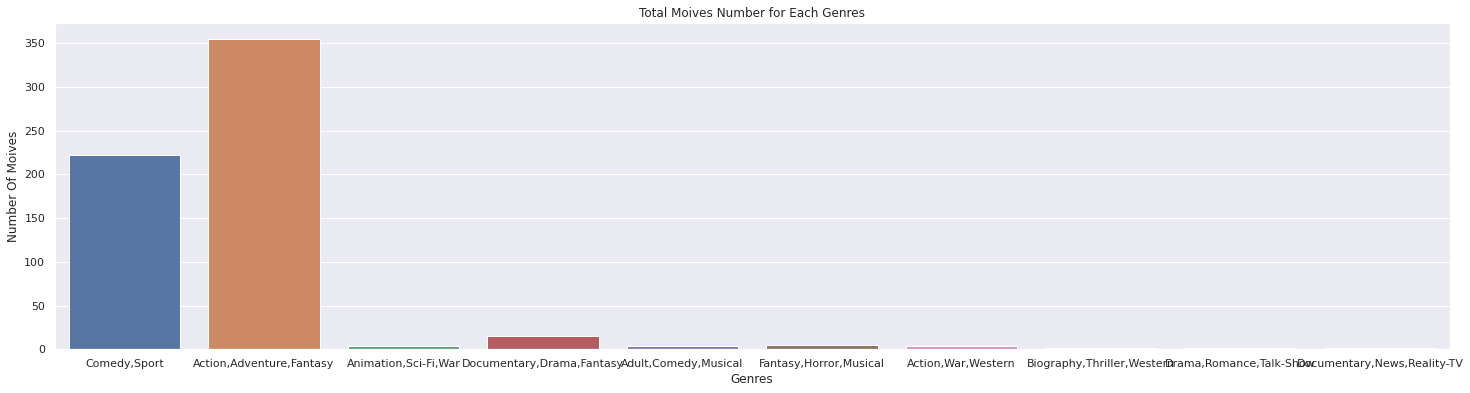

In [19]:
master_data_tb.createOrReplaceTempView('master_data_tb')

query = """
  SELECT  DISTINCT(genres) AS genres, 
          COUNT(DISTINCT(movie_id)) AS movies_count
  FROM master_data_tb
  WHERE titleType=='movie'
  GROUP BY genres
  Limit 10
"""

res = spark.sql(query)

sns.set_style("darkgrid")
sns.set(rc={"figure.figsize":(25,6)})
ax = sns.barplot(x = "genres", y = "movies_count", data = res.toPandas())
ax.set(title = "Total Moives Number for Each Genres", xlabel = "Genres", ylabel = "Number Of Moives");

▶ These are the top 10 movies genres. Found that "Action, Adventure & Fantasy" is the top genres watched after that the "Comdey & Sport" moives

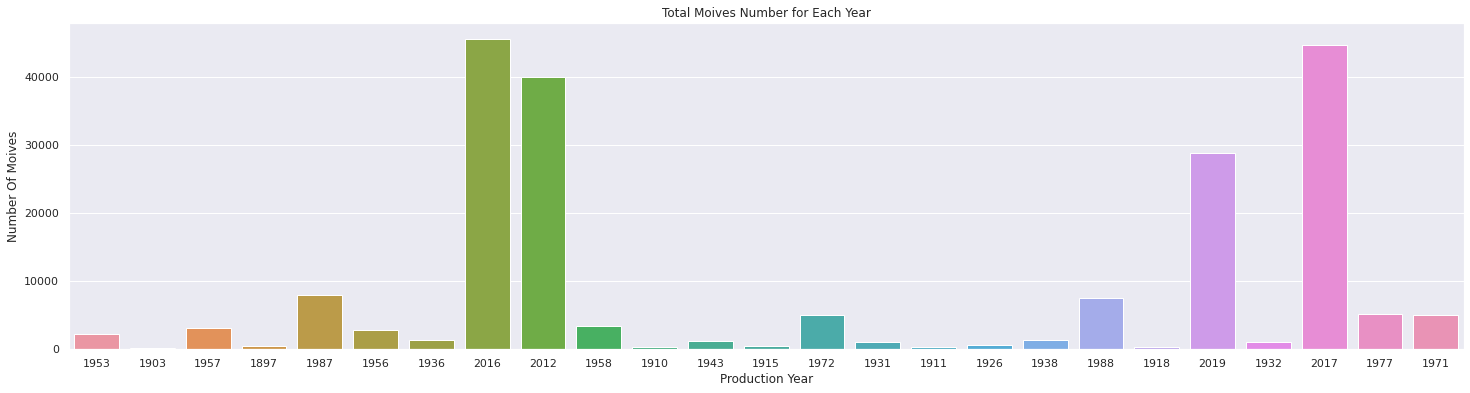

In [20]:
master_data_tb.createOrReplaceTempView('master_data_tb')

query = """
  SELECT  DISTINCT(startYear) AS years, 
          COUNT(DISTINCT(movie_id)) AS movies_count 
  FROM master_data_tb
  GROUP BY startYear
  LIMIT 25
"""


res = spark.sql(query)

sns.set_style("darkgrid")
sns.set(rc={"figure.figsize":(25,6)})
ax = sns.barplot(x = "years", y = "movies_count", data = res.toPandas())
ax.set(title = "Total Moives Number for Each Year", xlabel = "Production Year", ylabel = "Number Of Moives");

▶ These are the top 25 years that movies was produced in. Found that the top years are 2016 & 2017.

In [21]:
from pyspark.sql.functions import size, explode, col, split
query = master_data_tb.select(split(col("knownForTitles"),",").alias("knownForTitles"))
res = query.select('*',size('knownForTitles').alias('ApperanceInMovies'))
res = res.groupBy('ApperanceInMovies').count()
res.withColumnRenamed('count','NumberOfActors').sort('ApperanceInMovies',ord='desc').show()


+-----------------+--------------+
|ApperanceInMovies|NumberOfActors|
+-----------------+--------------+
|                1|        518659|
|                2|        262033|
|                3|        241405|
|                4|       7260206|
|                5|           110|
|                6|            16|
|                7|             2|
|                8|             8|
+-----------------+--------------+



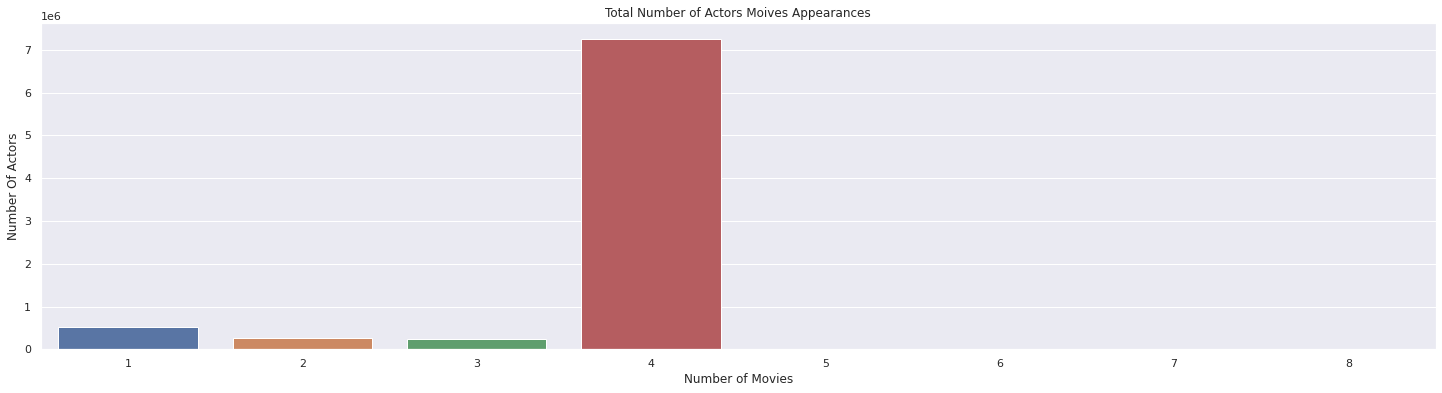

In [22]:
sns.set_style("darkgrid")
sns.set(rc={"figure.figsize":(25,6)})
ax = sns.barplot(x = "ApperanceInMovies", y = "count", data = res.toPandas())
ax.set(title = "Total Number of Actors Moives Appearances", xlabel = "Number of Movies", ylabel = "Number Of Actors");

▶ These are the most frequence for actors participated in movies. Found that most of actors participated in 4 movies.

In [23]:
master_data_tb.createOrReplaceTempView('master_data_tb')

query = """
  SELECT  DISTINCT(isAdult) AS adult, 
          COUNT(DISTINCT(movie_id)) AS movies_count
  FROM master_data_tb
  WHERE titleType=='movie'
  GROUP BY isAdult
"""
res = spark.sql(query)
res = res.toPandas()

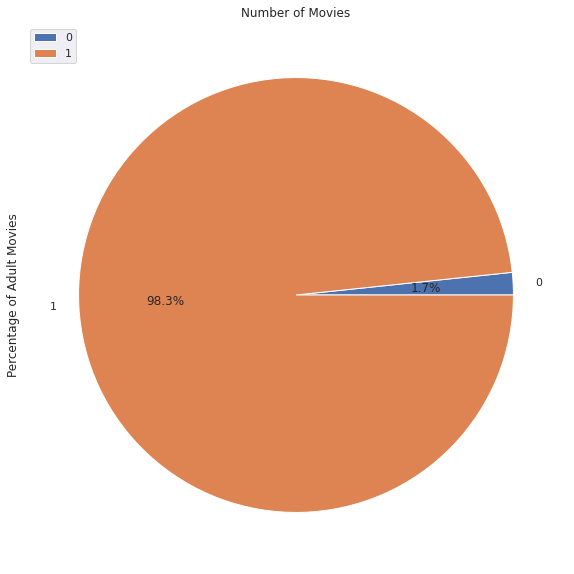

In [24]:
#res = res.set_index()

pie = res.plot.pie(y = "movies_count", figsize = (10,10), autopct = "%1.1f%%")
pie.legend(loc = "upper left");
pie.set(title = "Number of Movies", ylabel = "Percentage of Adult Movies");

▶ Here the percentage of Adult movies vs non adult movie. Found that Adult movies percentage is 98.3 %

# Implement A-Prior Algorithm

In [25]:
from pyspark.sql.functions import split, explode, col
actors_df = names.filter((names.primaryProfession =='acotr') | (names.primaryProfession =='actress') & (names.knownForTitles !='\\N'))
actors_df.cache()
actors_df_reduced = actors_df.drop('birthYear','deathYear','primaryProfession')
actors_df_explode = actors_df_reduced.select(names.nconst,names.primaryName,explode(split(col("knownForTitles"), ",\s*")))
actors_df_explode.printSchema()
actors_df_explode.show()

root
 |-- nconst: string (nullable = true)
 |-- primaryName: string (nullable = true)
 |-- col: string (nullable = true)

+---------+-----------------+---------+
|   nconst|      primaryName|      col|
+---------+-----------------+---------+
|nm0000084|          Li Gong|tt0473444|
|nm0000084|          Li Gong|tt0101640|
|nm0000084|          Li Gong|tt0397535|
|nm0000084|          Li Gong|tt0430357|
|nm0000109|   Yasmine Bleeth|tt0131857|
|nm0000109|   Yasmine Bleeth|tt0115285|
|nm0000109|   Yasmine Bleeth|tt0337851|
|nm0000109|   Yasmine Bleeth|tt0119271|
|nm0000124|Jennifer Connelly|tt0315983|
|nm0000124|Jennifer Connelly|tt0180093|
|nm0000124|Jennifer Connelly|tt0268978|
|nm0000124|Jennifer Connelly|tt0102803|
|nm0000143|    Erika Eleniak|tt0083866|
|nm0000143|    Erika Eleniak|tt0094761|
|nm0000143|    Erika Eleniak|tt0106400|
|nm0000143|    Erika Eleniak|tt0105690|
|nm0000157|   Linda Hamilton|tt0103064|
|nm0000157|   Linda Hamilton|tt6450804|
|nm0000157|   Linda Hamilton|tt0088247

In [36]:
from pyspark.sql import functions as F
transactions= actors_df_explode.groupby("col").agg(F.collect_list("primaryName").alias('actor_name'), F.collect_list("nconst").alias('actor_id'))
transactions.show()

+---------+--------------------+--------------------+
|      col|          actor_name|            actor_id|
+---------+--------------------+--------------------+
|tt0001170|    [Clara Williams]|         [nm0930290]|
|tt0002591|[Martha Angerstei...|         [nm0029806]|
|tt0003689|    [Mrs. E. Walton]|         [nm0910564]|
|tt0004272|      [Eva Thatcher]|         [nm0857118]|
|tt0004336|[Mae Tinee, Lila ...|[nm1754381, nm015...|
|tt0004599|    [Lucille Bolton]|         [nm0093420]|
|tt0005605|     [Minnie Berlin]|         [nm0075601]|
|tt0006204|[Blanche Bennett,...|[nm0071618, nm050...|
|tt0006207|[Francesca Cappel...|         [nm0135474]|
|tt0006587|     [Miriam Shelby]|         [nm0790977]|
|tt0006819|[Alice Hechy, Rut...|[nm0372991, nm065...|
|tt0007011|[Mary Bunting, Vi...|[nm0120577, nm092...|
|tt0007565|       [Hilda Moore]|         [nm0601280]|
|tt0007694|[Pinna Nesbit, In...|[nm0626341, nm078...|
|tt0008160|     [Nancy Caswell]|         [nm0145776]|
|tt0008407|[Olive Bruce, Vir

In [27]:
print((transactions.count(), len(transactions.columns)))

(577849, 3)


In [37]:
from pyspark.sql.functions import size, explode, col, split
transactions=transactions.select('*',size('actor_id').alias('NumberActors'))

In [38]:
transactions.show()

+---------+--------------------+--------------------+------------+
|      col|          actor_name|            actor_id|NumberActors|
+---------+--------------------+--------------------+------------+
|tt0001170|    [Clara Williams]|         [nm0930290]|           1|
|tt0002591|[Martha Angerstei...|         [nm0029806]|           1|
|tt0003689|    [Mrs. E. Walton]|         [nm0910564]|           1|
|tt0004272|      [Eva Thatcher]|         [nm0857118]|           1|
|tt0004336|[Mae Tinee, Lila ...|[nm1754381, nm015...|           6|
|tt0004599|    [Lucille Bolton]|         [nm0093420]|           1|
|tt0005605|     [Minnie Berlin]|         [nm0075601]|           1|
|tt0006204|[Blanche Bennett,...|[nm0071618, nm050...|           3|
|tt0006207|[Francesca Cappel...|         [nm0135474]|           1|
|tt0006587|     [Miriam Shelby]|         [nm0790977]|           1|
|tt0006819|[Alice Hechy, Rut...|[nm0372991, nm065...|           4|
|tt0007011|[Mary Bunting, Vi...|[nm0120577, nm092...|         

In [39]:
# Apriori Alogrithm

import itertools
from collections import defaultdict

def getCandidateItemsets(frequents,k):
    elements=set() #set of single items
   
    #for candidate triples,quadruples,..
    if(k>2):
        for itemsets in frequents: 
            for item in itemsets: 
                elements.add(item) 
    
    #for candidate pairs
    elif(k==2):
        for item in frequents:   
            elements.add(item) 
    
    #get candidate items (pairs, triples,..) by combining single items 
    candidateItemsets=[set(itemsets) for itemsets in list(itertools.combinations(elements, k))] 
    
    return candidateItemsets

    
def getFrequentItemsets(candidateItemsets,transactions,support):
    itemsetsFrequency = defaultdict(int) 
    baskets= transactions.collect()
    
    #calculate the frequency for each candidate itemset in the baskets
    for itemset in candidateItemsets: 
        for basket in baskets: 
            if itemset.issubset(basket): 
                itemsetsFrequency[frozenset(itemset)] += 1 

    #retain only frequent itemsets
    frequentItemsets= []   
    for item in itemsetsFrequency.items(): 
        if item[1] >= support: 
            frequentItemsets.append(item) 

    return frequentItemsets

def aprioriAlgorithm(transactions, support):
  apriori_frequent=[]
  singletonMap= transactions.flatMap(lambda line: line).map(lambda item: (item , 1))
  singletonMap=singletonMap.reduceByKey(lambda a,b: (a+b))
  frequentSingletons= singletonMap.filter(lambda item: item[1] >= support)
  frequents= frequentSingletons.map(lambda item: item[0]).collect()
  apriori_frequent= frequentSingletons.collect()

  k=2
  while(len(frequents) != 0):   
        #retrive list of candidate pairs, triples, ...
        candidateItemsets=getCandidateItemsets(frequents,k) 
        #retain candidate pairs, triples... that are frequent  
        frequentItemsets=getFrequentItemsets(candidateItemsets,transactions,support)
        if (frequentItemsets): 
            apriori_frequent.append(frequentItemsets)  
        frequents=frequentItemsets 
        k=k+1 


  return apriori_frequent

In [40]:
#get transactions from table
transactions= transactions.select('actor_id').rdd.flatMap(lambda x: x)
lines = transactions.map(lambda line: ','.join(str(d) for d in line))
lines.saveAsTextFile('transactions_actors_singlerole.txt')
trans = sc.textFile('transactions_actors_singlerole.txt').map(lambda x: [str(y) for y in x.strip().split(',')])

In [41]:
#apply Apriori
import time
start_time = time.time()
minSupport = 5
aprioriResult = aprioriAlgorithm(trans, minSupport)
aprioritime = time.time() - start_time
print(" Apriori Algorithm Executed in %.3f Seconds" % (aprioritime))

 Apriori Algorithm Executed in 78.782 Seconds


In [42]:
#display apriori result
aprioriResult

[('nm1948317', 5),
 ('nm5756622', 5),
 ('nm2838205', 5),
 ('nm0891937', 5),
 ('nm5457566', 5),
 ('nm0686428', 5),
 ('nm1708736', 5),
 ('nm3304752', 5),
 ('nm0472407', 6),
 ('nm5613952', 5),
 ('nm0361727', 5),
 ('nm1163810', 5)]

# Implement FP-Growth Algorithm

## Generation of baskets

For using FP-growth, first, we would be creating baskets of each order in our dataset.

We would do so by creating a baskets data frame having 2 columns: first, the actor_id and actor_name

In [43]:
### Create Baskets
baskets = """
SELECT movie_id, actor_id, actor_name
FROM   master_data_tb
WHERE  titleType == 'movie' AND (category =='actor' OR category =='actress')
"""

a = spark.sql(baskets)
basket_data = a.groupBy('movie_id').agg(collect_set('actor_id').alias('actor_id'), collect_set('actor_name').alias('actor_name'))
basket_data.createOrReplaceTempView('basket_data')
basket_data.show(5,False)

+---------+---------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------+
|movie_id |actor_id                                                                                           |actor_name                                                                                                                           |
+---------+---------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------+
|tt0004272|[nm0092665, nm0368875, nm0492302, nm0445507, nm0776747, nm0383278, nm0192062, nm0285643, nm0793189]|[Wilbur Higby, Francis Ford, Harry Schumm, Ernest Shields, Eddie Boland, Jean Hathaway, Edgar Keller, Burton Law, Grace Cunard]      |
|tt0004336|[nm02

In [44]:
from pyspark.ml.fpm import FPGrowth

fpGrowth = FPGrowth(itemsCol="actor_name", minSupport=0.0001, minConfidence=0)
model = fpGrowth.fit(basket_data)

In [45]:
startTime = time.time()
fptime = time.time() - startTime
print("FP-Growth Algorithm Executed in %.3f Seconds"%(fptime))

FP-Growth Algorithm Executed in 0.000 Seconds


Displaying of frequent itemsets, association rules and predictions

Here, we would be using spark.ml’s FP-growth package for implementation.

For FP-growth, no hyperparameter tuning is performed (you can try to perform it as an exercise, by using the prior orders table as validation/test set).

In [46]:
# Display frequent
most_freq = model.freqItemsets
most_freq = most_freq.sort('Freq',ascending = False)
most_freq.createOrReplaceTempView('most_freq')
most_freq.show(10, False)

+--------------------+----+
|items               |freq|
+--------------------+----+
|[Brahmanandam]      |412 |
|[Mohanlal]          |321 |
|[Mammootty]         |312 |
|[Mithun Chakraborty]|298 |
|[Cüneyt Arkin]      |281 |
|[Sridevi]           |242 |
|[Dharmendra]        |237 |
|[Ron Jeremy]        |228 |
|[Tom Byron]         |227 |
|[Jagathi Sreekumar] |218 |
+--------------------+----+
only showing top 10 rows



In [47]:
# Display Association rules.
associationRules = model.associationRules
associationRules.createOrReplaceTempView("associationRules")
associationRules.show(4, False)

+---------------+-------------------+------------------+------------------+---------------------+
|antecedent     |consequent         |confidence        |lift              |support              |
+---------------+-------------------+------------------+------------------+---------------------+
|[Ric Lutze]    |[Rene Bond]        |0.4492753623188406|1688.140350877193 |1.4474077394292545E-4|
|[Jayalalitha J]|[M.G. Ramachandran]|0.3               |676.3452631578947 |1.1205737337516809E-4|
|[Jayalalitha J]|[Nagesh]           |0.3375            |463.3615384615385 |1.260645450470641E-4 |
|[Ray Corrigan] |[Max Terhune]      |0.8723404255319149|3336.3282674772036|1.9143134618257882E-4|
+---------------+-------------------+------------------+------------------+---------------------+
only showing top 4 rows



In [48]:
# Association rules prediction
associations = model.transform(basket_data)
associations.show(20,False)

+---------+---------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------+----------+
|movie_id |actor_id                                                                                           |actor_name                                                                                                                           |prediction|
+---------+---------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------+----------+
|tt0004272|[nm0092665, nm0368875, nm0492302, nm0445507, nm0776747, nm0383278, nm0192062, nm0285643, nm0793189]|[Wilbur Higby, Francis Ford, Harry Schumm, Ernest Shields, Eddie Boland, Jean Hathaway, Edgar Keller, Burton Law, Grac

Most frequent actors/actress of items (containing at least 2 items).

In [49]:
query = """ SELECT items, freq
            FROM most_freq
            WHERE size(items) >=2
            limit 100 """
spark.sql(query).show(20,False)

+-----------------------------------+----+
|items                              |freq|
+-----------------------------------+----+
|[Balkrishna, Rajkumar]             |74  |
|[Ciccio Ingrassia, Franco Franchi] |72  |
|[Leo Gorcey, Huntz Hall]           |59  |
|[Ali, Brahmanandam]                |52  |
|[Kiyoshi Atsumi, Chieko Baishô]    |52  |
|[Gene Autry, Smiley Burnette]      |50  |
|[Peter North, Tom Byron]           |49  |
|[Nedumudi Venu, Mohanlal]          |47  |
|[Trigger, Roy Rogers]              |47  |
|[M.G. Ramachandran, M.N. Nambiar]  |47  |
|[Raymond Hatton, Johnny Mack Brown]|45  |
|[Ashwath, Rajkumar]                |42  |
|[Roy Rogers, George 'Gabby' Hayes] |41  |
|[Ray Corrigan, Max Terhune]        |41  |
|[Mammootty, Mohanlal]              |40  |
|[Leelavathi, Rajkumar]             |40  |
|[Udaya Kumar, Rajkumar]            |40  |
|[Mohan Babu, Brahmanandam]         |39  |
|[Aachi Manorama, Shivaji Ganesan]  |39  |
|[Nagesh, Shivaji Ganesan]          |39  |
+----------

The most frequent actors working together are "Balkrishna & Rajkumar" with frequent 74

Association rules

A good way to think about association rules is that model determines that if you actor 1 (i.e. the antecedent), then you will actor 2 this other thing (i.e. the consequent) with the following confidence.

In [57]:
query = """select antecedent as `antecedent (if)`, consequent as `consequent (then)`, confidence
           from associationRules
           order by confidence desc
           limit 20"""

spark.sql(query).show(20, False)

+----------------------------------+-----------------+------------------+
|antecedent (if)                   |consequent (then)|confidence        |
+----------------------------------+-----------------+------------------+
|[Nobuyo Ôyama, Kaneta Kimotsuki]  |[Noriko Ohara]   |1.0               |
|[Black Jack]                      |[Allan Lane]     |1.0               |
|[Larry Simms]                     |[Penny Singleton]|1.0               |
|[Larry Simms]                     |[Arthur Lake]    |1.0               |
|[Champion]                        |[Gene Autry]     |1.0               |
|[Nobuyo Ôyama, Michiko Nomura]    |[Noriko Ohara]   |1.0               |
|[Larry Simms, Penny Singleton]    |[Arthur Lake]    |1.0               |
|[Gabriel Dell, Leo Gorcey]        |[Huntz Hall]     |1.0               |
|[Michiko Nomura, Kaneta Kimotsuki]|[Noriko Ohara]   |1.0               |
|[Penny Singleton, Arthur Lake]    |[Larry Simms]    |1.0               |
|[Larry Simms, Arthur Lake]        |[P

# Implement N-GRAM Algorithm

In [59]:
from pyspark.ml.feature import NGram
ngram = NGram(n=2, inputCol ="actor_name", outputCol="bigrams")
ngram_df = ngram.transform(basket_data)
ngram_df.show(20,False)

+---------+---------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|movie_id |actor_id                                                                                           |actor_name                                                                                                                           |bigrams                                                                                                                                                                                                                          |
+---------+---------------------------------------------

In [52]:
bigrams = ngram_df.toPandas()['bigrams']

In [53]:
table = {}
total = len(bigrams)
completion = 0
for bigram in bigrams:
  for combination in bigram:
    components = combination.split(' ')
    key = components[0]
    valKey = components[1]
    if key in table:
      valDict = table[key]
      if valKey in valDict:
        valDict[valKey] = valDict[valKey] +1
      else:
        valDict[valKey]=1
    else:
      valDict = {valKey: 1}
      table[key] = valDict
      
    completion +=1


In [54]:
startTime = time.time()
ngramtime = time.time() - startTime
print("N-Gram Algorithm Executed in %.3f Seconds"%(ngramtime))

NGram Algorithm Executed in 0.000 Seconds


Showing the frequency between different actors and actress working together in more than 10 movies


In [73]:
for a in table:
  for b in table[a]:
    if table[a][b] > 10:
      print(a,"&",b,":",table[a][b])

Streaming output truncated to the last 5000 lines.
Mercedes & Cabral : 18
Mercedes & Carreño : 12
Mercedes & Sampietro : 29
Mercedes & Carreras : 11
Caio & Blat : 15
Dirk & Benedict : 14
Dirk & Bogarde : 53
Nia & Long : 18
Pejman & Bazeghi : 25
Aleksandar & Bercek : 26
Aleksandar & Gavric : 13
Kaushik & Ganguly : 12
Kaushik & Banerjee : 18
Laurent & Grévill : 14
Laurent & Terzieff : 27
Laurent & Lucas : 14
Laurent & Lafitte : 18
Laurent & Malet : 14
Firat & Tanis : 16
Virginie & Caillat : 15
Virginie & Ledoyen : 28
Virginie & Efira : 21
Gil & Lagardère : 12
Gil & Bellows : 27
Aparna & Balamurali : 13
Aparna & Sen : 39
Asif & Ali : 54
Asif & Khan : 11
Sreenivasan & Jayaram : 12
Mariya & Vinogradova : 12
Casper & Van : 27
Stacey & Dash : 15
Stacey & Donovan : 29
Álvaro & de : 17
Vanessa & Redgrave : 52
Vanessa & del : 58
Vanessa & Paradis : 19
Shruti & Haasan : 20
P. & Ravi : 21
P. & Ramlee : 30
Prakash & Belawadi : 11
Prakash & Raj : 179
Achyuth & Kumar : 32
Sadhu & Kokila : 49
Tiger & 

# Comparison Between A-Priori Algorithm vs FP-Growth Algorithm vs N-Gram Algorithm Execution Time

A-Prior Algorithm Running Time: 78.78182482719421
FP-Growth Algorithm Running Time: 3.814697265625e-05
NGram Algorithm Running Time: 4.1961669921875e-05


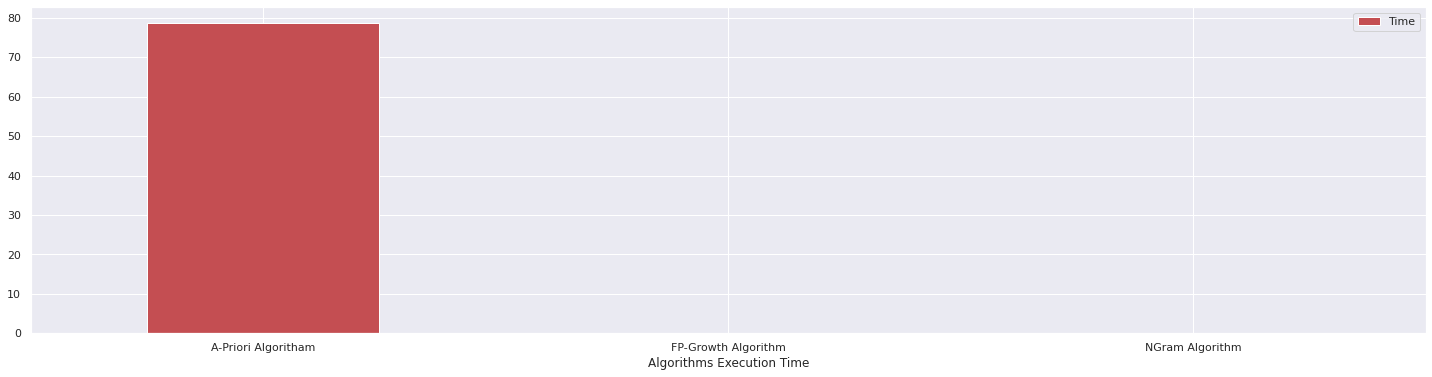

In [56]:
comp_df = pd.DataFrame({'Algorithms Execution Time':['A-Priori Algoritham','FP-Growth Algorithm','N-Gram Algorithm'],'Time':[aprioritime,fptime,ngramtime]})
print("A-Prior Algorithm Running Time:",aprioritime)
print("FP-Growth Algorithm Running Time:",fptime)
print("N-Gram Algorithm Running Time:",ngramtime)
rpolt = comp_df.plot.bar(x='Algorithms Execution Time', y='Time', rot=0, color='r')